In [23]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import re
import matplotlib.pyplot as plt

df = pd.read_csv("fake_news_dataset.csv")
texts = df["text"].astype(str).tolist()
labels, uniques = pd.factorize(df["label"])   #The factorize function in pandas is used to make two kinds of lists one of which are number forms of the labels, i.e. 1 for Real and 0 for Fake
num_classes = len(uniques)  #What are the unique labels in the uniques list

In [24]:
def clean_text(s):
    s = str(s).lower()                          
    s = re.sub(r'http\S+|www\.\S+', '', s)       
    s = re.sub(r'<.*?>', '', s)                  
    s = re.sub(r'[^a-z0-9\s]', ' ', s)           
    s = re.sub(r'\s+', ' ', s).strip()           
    return s

df['text'] = df['text'].apply(clean_text)
df['label'] = df['label'].astype(str).str.strip().str.lower()
df = df.dropna(subset=['text', 'label'])

print("Rows after cleaning:", len(df))

Rows after cleaning: 20000


In [25]:
#This function is used to tokenize the text
def tokenizer(s): return s.lower().split()
all_tokens = [tokenizer(t) for t in texts]
vocab = {"<PAD>":0,"<UNK>":1}
for tokens in all_tokens:
    for w in tokens:
        if w not in vocab: vocab[w] = len(vocab)        #This line assigns each word of the text a unique number that represents the word

In [26]:
MAX_LEN = 20
def encode(tokens):
    ids = [vocab.get(w,1) for w in tokens]  #Makes a list of unique numbers assigned to each token in the text
    ids=ids[:MAX_LEN]       #Reduces the characters to the minimum number of characters required
    return ids + [0]*(MAX_LEN - len(ids))   #In case the list of the unique numbers is too low, we add zeroes to fill up the remaining space

X = torch.tensor([encode(t) for t in all_tokens], dtype=torch.long) 
y = torch.tensor(labels, dtype=torch.long)  

In [27]:
class M(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes):
        super().__init__()
        self.e = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.fc = nn.Linear(emb_dim, num_classes)
    def forward(self, x):
        z = self.e(x).mean(dim=1)
        return self.fc(z)

model = M(len(vocab), emb_dim=32, num_classes=num_classes)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [28]:
EPOCHS = 10
for ep in range(1, EPOCHS+1):
    model.train()
    logits = model(X)

In [29]:
acc = (model(X).argmax(1) == y).float().mean()
print(f"Final accuracy: {acc:.4f}")

Final accuracy: 0.5013


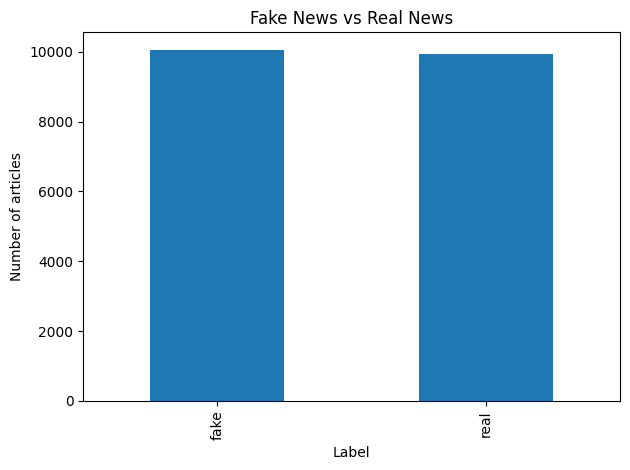

In [30]:
labels2 = df["label"]
# if labels are 0/1, map to readable names; otherwise use original label values
if set(labels2.unique()) <= {0, 1}:
    counts = labels2.map({0: "Fake", 1: "Real"}).value_counts().reindex(["Fake", "Real"]).fillna(0)
else:
    counts = labels2.value_counts()

plt.figure()
counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Number of articles")
plt.title("Fake News vs Real News")
plt.tight_layout()
plt.show()